# **Result Analysis -** Godot Navigation : Simpletown

___
___

### **0. Environments & Datasets**

#### A. Simpletown Maze Layouts

| Maze | 1 | 2 | 3 | 4 |
|---|---|---|---|---|
|  | <img src="../../../assets/environments/godot_goal/simpletown/simpletown_0_up.png" width="180px" alt="Simpletown Maze 1" /> | <img src="../../../assets/environments/godot_goal/simpletown/simpletown_1_up.png" width="180px" alt="Simpletown Maze 2" /> | <img src="../../../assets/environments/godot_goal/simpletown/simpletown_2_up.png" width="180px" alt="Simpletown Maze 3" /> | <img src="../../../assets/environments/godot_goal/simpletown/simpletown_3_up.png" width="180px" alt="Simpletown Maze 4" /> |
| **Maze** | **4** | **5** | **6** | **7** |
|  | <img src="../../../assets/environments/godot_goal/simpletown/simpletown_4_up.png" width="180px" alt="Simpletown Maze 5" /> | <img src="../../../assets/environments/godot_goal/simpletown/simpletown_5_up.png" width="180px" alt="Simpletown Maze 6" /> | <img src="../../../assets/environments/godot_goal/simpletown/simpletown_6_up.png" width="180px" alt="Simpletown Maze 7" /> | <img src="../../../assets/environments/godot_goal/simpletown/simpletown_7_up.png" width="180px" alt="Simpletown Maze 8" /> |

#### B. Simpletown Example Trajectories

| Maze | 0 | 1 | 2 | 3 |
|---|---|---|---|---|
|  | <img src="../../../assets/environments/godot_goal/simpletown/simpletown_0.gif" width="180px" alt="Simpletown Maze 1 GIF" /> | <img src="../../../assets/environments/godot_goal/simpletown/simpletown_1.gif" width="180px" alt="Simpletown Maze 2 GIF" /> | <img src="../../../assets/environments/godot_goal/simpletown/simpletown_2.gif" width="180px" alt="Simpletown Maze 3 GIF" /> | <img src="../../../assets/environments/godot_goal/simpletown/simpletown_3.gif" width="180px" alt="Simpletown Maze 4 GIF" /> |
| **Maze** | **4** | **5** | **6** | **7** |
|  | <img src="../../../assets/environments/godot_goal/simpletown/simpletown_4.gif" width="180px" alt="Simpletown Maze 5 GIF" /> | <img src="../../../assets/environments/godot_goal/simpletown/simpletown_5.gif" width="180px" alt="Simpletown Maze 6 GIF" /> | <img src="../../../assets/environments/godot_goal/simpletown/simpletown_6.gif" width="180px" alt="Simpletown Maze 7 GIF" /> | <img src="../../../assets/environments/godot_goal/simpletown/simpletown_7.gif" width="180px" alt="Simpletown Maze 8 GIF" /> |

The mazes in Simpletown are small, and the variations consist of different closed doors. All trajectories are human-generated.

___

### **1. Initialization**

#### *1.A. Imports*

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
import pandas as pd
import seaborn as sns

from offbench.utils.logger import extract_metrics_from_event_file
from offbench.utils.paths import WORKSPACE_PATH
from hydra import compose, initialize
from omegaconf import DictConfig
from typing import Union

#### *1.B. Data*

In [3]:
all_experiments_folder_path = os.path.join(WORKSPACE_PATH, "experiments", "1_singletask", "godot_goal")

seeds = [100 * i for i in range(1, 11)]

env_name = "simpletown"

env_name_to_title = {"simpletown": "SimpleTown"}

mazes = [f"maze_{i}" for i in range(8)]

maze_to_title = {f"maze_{i}": f"Maze {i}" for i in range(8)}

agent_ids = [
    "gcbc_base_mlp",
    "hgcbc_base_mlp",
]

agent_id_to_algo = {
    "gcbc_base_mlp": "GCBC",
    "hgcbc_base_mlp": "HGCBC"
}

In [4]:
performances = []

for maze in mazes:
        
    for agent_id in agent_ids:
        
        for seed in seeds:

            experiment_folder_path = os.path.join(all_experiments_folder_path, env_name + "-" + maze, agent_id, f"seed_{seed}")
            path_to_logs = os.path.join(experiment_folder_path, "logs")

            if not os.path.exists(path_to_logs): continue

            events_files = os.listdir(path_to_logs)
            events_files = [f for f in events_files if "events.out.tfevents" in f]

            all_metrics = []

            for events_file in events_files:

                metrics = extract_metrics_from_event_file(path_to_logs + "/" + events_file)

                for tag,step,value in metrics:
                    if tag.startswith("EVALUATION"):
                        all_metrics.append({
                            "maze": maze,
                            "algo": agent_id_to_algo[agent_id],
                            "seed": seed,
                            "metric": tag.split("/")[-1],
                            "value": value,
                            "gradient_step": step,
                        })
                
                try:
                
                    df = pd.DataFrame(all_metrics)
                    df = df.pivot_table(index=["maze","algo","seed","gradient_step"],columns="metric",values="value")
                    df = df.reset_index(drop=False)
                
                except:

                    print(f"Error with {experiment_folder_path}")
                
                performances.append(df)

performances = pd.concat(performances)
performances = performances.reset_index(drop=True)
performances = performances.rename(columns={"mean_discounted_return": "discounted_return"})
performances = performances.rename(columns={"mean_length": "length"})
performances = performances.rename(columns={"mean_success": "success"})
performances = performances.rename(columns={"mean_undiscounted_return": "undiscounted_return"})

___

### **2. Tables**

In [15]:
# keep last evaluation (for last gradient step)
performances_table = performances[performances["gradient_step"] == 100000]
performances_table = performances_table[["maze","algo","success","length","seed"]]

# average over seeds
performances_table = performances_table.groupby(["maze","algo"]).agg(
    mean_success=("success","mean"),
    std_success=("success","std"),
    mean_length=("length","mean"),
    std_length=("length","std")
).reset_index(drop=False)
performances_table = performances_table.rename(columns={
    "mean_success": "score", 
    "std_success": "std_score",
    "mean_length": "length",
    "std_length": "std_length"
})

# put it all niceley
performances_table = performances_table.pivot_table(index=["maze"],columns="algo",values=["score","std_score","length","std_length"])
performances_table = performances_table[["score","std_score","length","std_length"]]
# round score
performances_table["score"] = (100 * performances_table["score"]).round(1)
performances_table["std_score"] = (100 * performances_table["std_score"]).round(1)
# round length
performances_table["length"] = performances_table["length"].round(1)
performances_table["std_length"] = performances_table["std_length"].round(1)
# sort columns
performances_table = performances_table.swaplevel(axis=1)
performances_table = performances_table.loc[mazes]

# sort columns
performances_table = performances_table[["GCBC", "HGCBC"]]

In [16]:
performances_table.round(3)

algo    GCBC                             HGCBC                            
       score std_score length std_length score std_score length std_length
maze                                                                      
maze_0  98.9       0.8   50.9        2.3  97.6       1.7   50.8        2.2
maze_1  97.6       1.2   55.8        1.4  97.1       2.1   55.0        1.7
maze_2  95.5       1.5   59.4        1.6  96.6       2.0   57.4        1.8
maze_3  91.3       3.0   60.9        2.5  97.5       1.3   55.8        1.8
maze_4  93.8       0.9   59.5        1.4  97.6       1.3   56.1        1.2
maze_5  92.4       3.0   68.8        1.8  97.4       1.2   66.1        1.3
maze_6  94.2       2.5   60.3        1.5  98.5       0.9   57.2        1.5
maze_7  92.0       1.8   67.8        2.0  95.8       1.8   65.8        2.6

___

### **3. Plots**

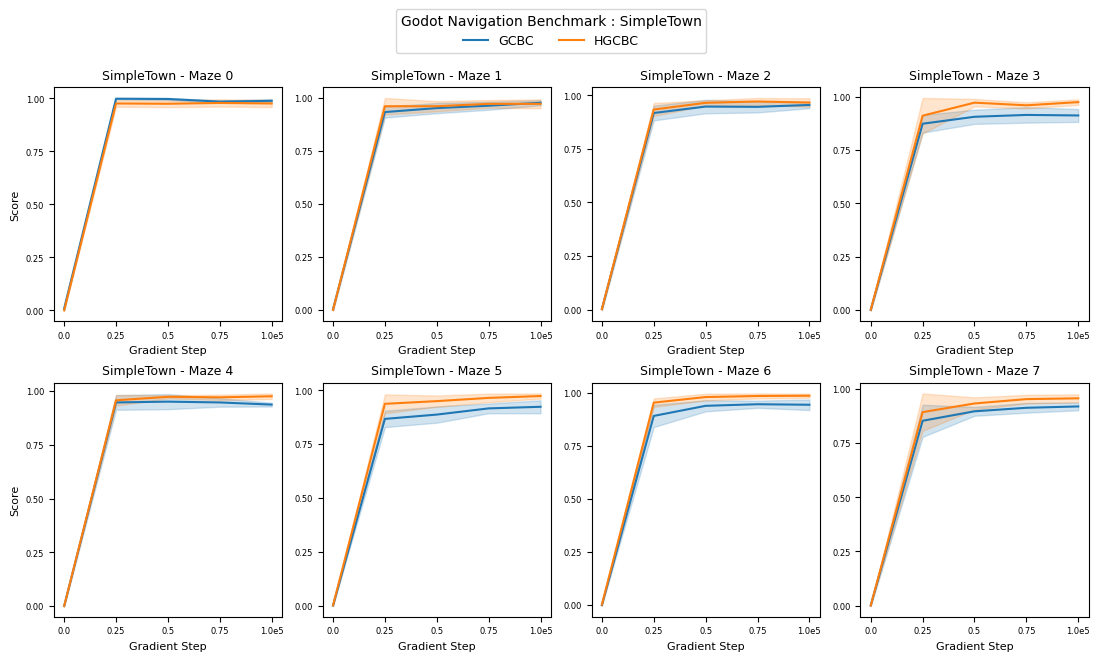

In [7]:
plt.rc('font', size=6)

fig, axes = plt.subplots(2, 4, figsize=(11, 6), sharex=False, sharey=False)

for k in range(8):
        
    maze = f"maze_{k}"
        
    i = k // 4
    j = k % 4

    ax = axes[i, j]

    data = performances[performances["maze"] == maze]

    sns.lineplot(
        data=data,
        x="gradient_step",
        y="success",
        hue="algo",
        ax=ax,
        errorbar="sd",
    )

    ax.set_title(f"{env_name_to_title[env_name]} - {maze_to_title[maze]}", fontsize=9)

    ax.set_xlabel("Gradient Step", fontsize=8)
    ax.set_xticks([0, 25000, 50000, 75000, 100000])
    ax.tick_params(axis='x', labelsize=6)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e5}e5' if x == 100000 else f'{x/1e5}'))

    if j == 0: ax.set_ylabel("Score", fontsize=8)
    else: ax.set_ylabel("")
    ax.set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
    ax.tick_params(axis='y', labelsize=6)

    # no legend for the moment
    ax.get_legend().remove()

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(labels), fontsize=9, title="Godot Navigation Benchmark : SimpleTown", bbox_to_anchor=(0.5, 1.095), title_fontsize=10)

plt.tight_layout()
plt.show()

___
___